In [1]:
##########################################################
############         LOAD MODULES           ##############
##########################################################
import sys
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# https://mido.readthedocs.io/en/latest/installing.html
# pip install mido
import mido

# pretty_midi by Colin Raffel and Daniel P.W. Ellis
# https://colinraffel.com/publications/ismir2014intuitive.pdf
# https://craffel.github.io/pretty-midi/
# pip install pretty_midi
import pretty_midi

# music21 from Michael Cuthbert and students in his research lab
# https://github.com/cuthbertLab/music21
# pip install music21
import music21

***       MIDI PROCESSING      ***

To process the music files in MIDI format, we will need a python intrepeter.  A brief literature and blog search yielded 3 common MIDI interpreter modules for python.

Mido: https://mido.readthedocs.io/en/latest/installing.html
Pretty_Midi: https://craffel.github.io/pretty-midi/
music21: https://github.com/cuthbertLab/music21

Of these, Mido is the most basic, with Pretty_Midi being built on top of it (and maybe music21, but that I'm not 100\% clear on).  Initially I attempted to use music21 but quickly found that too much was being abstracted away which was adding increased time and difficulty trying to understand the documentation.

Thus I settled on Pretty_Midi for the majority of my MIDI processing needs and wrote some wrappers around it to simplify my use-cases.

To help me understand the syntax for these MIDI interpreters, I referenced their documentation as well as the following blog posts/articles:

https://github.com/sandershihacker/midi-classification-tutorial/blob/master/midi_classifier.ipynb

https://nbviewer.org/github/craffel/midi-ground-truth/blob/master/Statistics.ipynb

https://github.com/imalikshake/StyleNet/blob/master/midi_util.py

https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

https://github.com/Skuldur/Classical-Piano-Composer

In [4]:
#################################################################################
#############     DATA STRUCTURES AND FUNCTIONS FOR PROCESSING      #############
#################################################################################

# Helper functions
# Given a chord (here meaning more than one note played at once on a single instrument)
# determine whether it is Consonant or Dissonant
# It is expected that the frequency of dissonance could help distinguish composers from one another
# FIXME: Due to the limitations of my processing approach, this is really only suitable for Piano
# jSymbolic features in the music21 module may have some better approaches to this
def checkDissonance(row):
    chord = []
    if (len(row['pitch']) == 1):
        row['chord'] = []
        row['consonant'] = -1
        return row
    for note in row['pitch']:
        chord.append(pretty_midi.note_number_to_name(note))
        row['chord'] = chord
        row['consonant'] = music21.chord.Chord(chord).isConsonant()
    
    return row


intervalNames = ['unison','minSecond','majSecond','minThird','majThird','fourth','tritone','fifth',
                 'minSixth','majSixth','minSeventh','majSeventh','octave']

# In music theory, frequency of various types of intervals are studied, so this is an attempt to 
# quantify those.  As in above, because of the way I'm processing these, only really suitable for
# Piano and jSymbolic may provide better options
def getInterval(row):
    for name in intervalNames:
        row[name] = 0

    shift = min(row['pitch'])
    interval = np.array(row['pitch']) - shift
    row['interval'] = interval
    
    if (len(row['pitch']) == 2):
        dist = np.abs(interval[0] - interval[1])
        if (dist > 0):
            dist = ((dist - 1) % 12) + 1
        row[intervalNames[dist]] = row[intervalNames[dist]] + 1
    
    return row


# This is a wrapper class around the pretty_midi modules
class ProcessPrettyMidi():
    def __init__(self, filepath):
        self.filepath = filepath
        # FIXME: I can certainly clean this up... this is quite hacky and doesn't really work
        # FIXME: Catch all exceptions and move on (very bad practice, but using it here for time...)
        try:
            self.composer = self.filepath.split('/')[-2].split('/')[0]
            if (''.join(self.filepath.split('/')[-1].split('_')[-2:]).split(".")[0] != '0'):
                self.piece = ''.join(self.filepath.split('/')[-1].split('_')[-2:]).split(".")[0]
            else:
                self.piece = self.filepath[-15:].split('_')[0]
        except:
            try:
                self.composer = 'Unknown'
                self.piece = self.filepath[-15:].split('_')[0]
            except:
                self.composer = 'Unknown'
                self.piece = 'Unknown'
        self.midiFile = pretty_midi.PrettyMIDI(self.filepath)
        self.music = []
        self.checkInstruments()
        self.getMusic()
        
    def checkInstruments(self):
        self.numInstruments = 0
        if (self.midiFile.instruments):
            self.numInstruments = len(self.midiFile.instruments)
      
    # Extract the note data from the MIDI files and store this in an DataFrame in an instrument array
    def getMusic(self):
        if (self.music):
            self.music = []
            
        if (self.numInstruments):
            for instrument in self.midiFile.instruments:
                if (not instrument.notes):
                    self.exit('Unable to find music for ' + str(instrument.program))
                instrumentName = pretty_midi.program_to_instrument_name(instrument.program)
                notesList = [[n.start, n.end, n.pitch, n.velocity, n.duration] for n in instrument.notes]
                notesDataFrame = pd.DataFrame(notesList, columns=['start','end','pitch','velocity','duration'])
                self.music.append({'name': instrumentName, 'notes': notesDataFrame})
        else:
            self.exit('Error: Was unable to read instruments')
            
    def displayInstruments(self):
        if (self.numInstruments):
            for instrument in self.music:
                print (instrument['name'])
   
    # Major analysis workhorse, parse the note data to calculate some derived quantities of interest for
    # analysis
    # FIXME: Look into deep learning approaches and how that may help/avoid manual feature extraction
    def parseMusic(self):
        if (self.numInstruments):
            for instrument in self.music:
                grouped = instrument['notes'].groupby(['start','duration'])
                
                stacks = grouped.count()
                stacks = stacks.groupby('end').count()['pitch']
                instrument['vertStacks'] = dict(zip(stacks.index.values, stacks.values))
    
                intervals = grouped.agg(lambda x: x.tolist())
                intervals = intervals.apply(getInterval, axis=1)
                intervals = intervals[intervalNames].sum()
                instrument['intervalCnt'] = dict(zip(intervals.index.values, intervals.values))

                consonance = grouped.agg(lambda x: x.tolist())
                consonance = consonance.apply(checkDissonance, axis=1)
                consonance = consonance.loc[consonance.consonant > -1]
                consonance = consonance.groupby('consonant').count()['pitch']
                if ((False in consonance) and (True in consonance)):
                    instrument['dissonancePct'] = consonance[False]/(consonance[True] + consonance[False])
                elif (True in consonance):
                    instrument['dissonancePct'] = 0.0
                else:
                    instrument['dissonancePct'] = 1.0
   
    # Some error catching
    def exit(self, msg):
        if (self.composer == 'Unknown'):
            print (msg, 'from', self.filepath)
        else:
            print (msg, 'from', self.piece, 'by', self.composer)
        sys.exit()

In [7]:
#################################################################################
###################            PARSE PS1 MIDI FILES           ###################
#################################################################################
composers = {'Bach','Beethoven','Brahms','Schubert'}
composerNumber = {'Bach': 0, 'Beethoven': 1, 'Brahms': 2, 'Schubert': 3}
columns = ['Composer','numInstruments','numPianos','numCellos','numPizzis','numViolins','numViolas',
           'numFrenchHorns','numOboes','numClarinets','numBassoons','numContras','numHarps','numFlutes',
           'otherInstPct','pianoDissonance','pianoSolo','pianoDouble',
           'pianoChord','pitchRange','meanDuration', 'coeffvarDuration']

# Create pickle directory if necessary
isExist = os.path.exists('MusicNet/PS1/pickle')
if (not isExist):
    os.makedirs('MusicNet/PS1/pickle')

# Loop through the PS1 files and process them, saving processed output into pickle files for 
# use in ModelBuilding.ipynb
baseDir = 'MusicNet/PS1/'
for comp in composers:
    pieces = glob.glob(baseDir + comp + "/*")
    for piece in pieces:
        try:
            pmidi = ProcessPrettyMidi(piece)
            fname = baseDir + "pickle/" + pmidi.composer + "-" + pmidi.piece.replace(" ", "_") + ".p"
            if (glob.glob(fname)):
                continue
            pmidi.parseMusic()            
            pickle.dump( pmidi, open( fname, "wb" ) )
            #print (pmidi.composer)
            #print (pmidi.piece)
        except:
            print ('Error processing', piece)
            continue
            

#################################################################################
###################            PARSE PS2 MIDI FILES           ###################
#################################################################################

# Create pickle directory if necessary
isExist = os.path.exists('MusicNet/PS2/pickle')
if (not isExist):
    os.makedirs('MusicNet/PS2/pickle')

# Loop through the PS2 files and process them, saving processed output into pickle files for 
# use in ModelBuilding.ipynb
baseDir = 'MusicNet/PS2/'
pieces = glob.glob(baseDir + "/*")
for piece in pieces:
    try:
        pmidi = ProcessPrettyMidi(piece)
        fname = baseDir + "pickle/" + piece.split('/')[-1].split('.')[1] + ".p"
        if (glob.glob(fname)):
            continue
        pmidi.parseMusic()            
        pickle.dump( pmidi, open( fname, "wb" ) )
        #print (pmidi.composer)
        #print (pmidi.piece)
    except:
        print ('Error processing', piece)
        continue
        
        
#################################################################################
###############    PARSE PS2 MIDI FILES IN 30 SECOND EXCERPTS    ################
#################################################################################        
# Choose a random start time
def randomTimes(pMidiFile, length=30):
    shift = (pMidiFile.get_end_time() - length)/2
    start = np.random.rand(1)*shift
    return np.array([[start, start+30],[start+shift, start+shift+30]])

# extract the 30 second region
def extractClip(notesDF, startTime, endTime):
    clip = notesDF.loc[(notesDF.end > startTime) & (notesDF.start < endTime)].copy()
    return clip
    
# Create pickle directory if necessary
isExist = os.path.exists('MusicNet/PS2/pickle-30')
if (not isExist):
    os.makedirs('MusicNet/PS2/pickle-30')

# Loop through the PS2 files and process them, saving processed output into pickle files for 
# use in ModelBuilding.ipynb
baseDir = 'MusicNet/PS2/'
pieces = glob.glob(baseDir + "/*")
for piece in pieces:
    #### FIXME: This gets very hacky and is not at all good coing practice or good OOP processes
    #### Needs to be improved
    try:
        pmidi1 = ProcessPrettyMidi(piece)
        pmidi2 = ProcessPrettyMidi(piece)
        fname1 = baseDir + "pickle-30/" + piece.split('/')[-1].split('.')[1] + "-1.p"
        fname2 = baseDir + "pickle-30/" + piece.split('/')[-1].split('.')[1] + "-2.p"
        if (glob.glob(fname1)):
            continue
        times = randomTimes(pmidi1.midiFile)
        
        for instrument in pmidi1.music:
            section = extractClip(instrument['notes'],times[0][0][0],times[0][1][0])
            if (section.empty):
                pmidi1.numInstruments = pmidi1.numInstruments - 1
            instrument['notes'] = section
        for instrument in pmidi2.music:
            section = extractClip(instrument['notes'],times[1][0][0],times[1][1][0])
            if (section.empty):
                pmidi2.numInstruments = pmidi2.numInstruments - 1
            instrument['notes'] = section  
            
        newMusic = []
        for instrument in pmidi1.music:
            if (instrument['notes'].empty):
                continue
            else:
                newMusic.append(instrument)
        pmidi1.music = newMusic

        newMusic = []
        for instrument in pmidi2.music:
            if (instrument['notes'].empty):
                continue
            else:
                newMusic.append(instrument)
        pmidi2.music = newMusic
        
        pmidi1.parseMusic()    
        pmidi2.parseMusic()
        pickle.dump( pmidi1, open( fname1, "wb" ) )
        pickle.dump( pmidi2, open( fname2, "wb" ) )
        #print (pmidi.composer)
        #print (pmidi.piece)
    except:
        print ('Error processing', piece)
        continue

Error processing MusicNet/PS1/Bach/WTK I, No. 14: Prelude and Fugue in F-sharp minor_BWV859_2305_prelude14.mid
Error processing MusicNet/PS2/pickle


***       QUICK NOTE      ***

I am going to ignore `Bach WTK I, No 14` as I am encountering some error in the MIDI file that the python parsers are unable to handle.  I believe it is unlikely to have much effect to miss a single file from Bach, though it is the only one in F-sharp minor, so would be nice to circle back to figure out a way to process it with additional time.  

Note that GarageBand on the Mac is able to play the file successfully so it doesn’t seem to be corrupted, just something the python parsers I’m using are having trouble with.

In [9]:
#################################################################################
###################             CREATE PS1 DATASET            ###################
#################################################################################
baseDir = 'MusicNet/PS1/'

dataset = []
for pFile in glob.glob(baseDir + "pickle/*"):
    # FIXME: Quick print error and skip file if processing breaks, but I need better error catching
    # This is mainly to avoid the need for babysitting this as it takes a few hours to run
    try:
        pMidi = pickle.load( open( pFile, "rb" ) )
        music = pMidi.music

        # First idea is to identify how many of each instrument there are
        # FIXME: This can almost certainly be abstracted better
        numPianos = 0
        numCellos = 0
        numViolins = 0
        numViolas = 0
        numFrenchHorns = 0
        numOboes = 0
        numClarinets = 0
        numBassoons = 0
        numPizzis = 0
        numContras = 0
        numFlutes = 0
        numHarps = 0
        numOthers = 0
        
        # Music Theory properties that really only work for the piano
        pianoDissonance = 0
        pianoDissonanceDenom = 0
        pianoDissonanceNumer = 0
        pianoSoloPct = 0
        pianoSoloPctNumer = 0
        pianoDoublePct = 0
        pianoDoublePctNumer = 0
        pianoChordPct = 0
        pianoChordPctNumer = 0
        pianoStacksDenom = 0
        
        # Some additional derived features idea, mainly determined by discussions with my
        # parents (both involved in playing classical music over the years) and some brief
        # examination of some of the MIDI files in GarageBand on the Mac
        pitchMin = 10000
        pitchMax = -10000
        durArray = np.array([])

        # Parse each instrument separately, this may not be the best approach
        # Note that music21 has a flatten option that collapses this, so there may be some 
        # merit to that, but more time is needed to investigate that
        for instrument in music:
            pitchMin = np.min([pitchMin, instrument['notes']['pitch'].min()])
            pitchMax = np.max([pitchMax, instrument['notes']['pitch'].max()])
            durArray = np.concatenate((durArray, np.array(instrument['notes']['duration'])))

            # instrument by instrument handling
            # mostly just have special circumstances for the Piano, but would be beneficial
            # to come up with derived quantities for each instrument and across instruments
            if (instrument['name'] == 'Acoustic Grand Piano'):
                numPianos = numPianos + 1
                thisPianoDissonanceDenom = 0 
                for key, value in instrument['vertStacks'].items():
                    if (key > 1):
                        thisPianoDissonanceDenom += value
                pianoDissonanceNumer += instrument['dissonancePct'] * thisPianoDissonanceDenom
                pianoDissonanceDenom += thisPianoDissonanceDenom
                if (1 in instrument['vertStacks']):
                    pianoSoloPctNumer += instrument['vertStacks'][1] 
                if (2 in instrument['vertStacks']):
                    pianoDoublePctNumer += instrument['vertStacks'][2]
                if (3 in instrument['vertStacks']):
                    pianoChordPctNumer += instrument['vertStacks'][3]
                if (1 in instrument['vertStacks']):
                    pianoStacksDenom += instrument['vertStacks'][1] + thisPianoDissonanceDenom

            elif (instrument['name'] == 'Violin'):
                numViolins = numViolins + 1

            elif (instrument['name'] == 'Viola'):
                numViolas = numViolas + 1

            elif ((instrument['name'] == 'Cello') or (instrument['name'] == 'Violincello')):
                numCellos = numCellos + 1

            elif (instrument['name'] == 'French Horn'):
                numFrenchHorns = numFrenchHorns + 1

            elif (instrument['name'] == 'Oboe'):
                numOboes = numOboes + 1

            elif (instrument['name'] == 'Clarinet'):
                numClarinets = numClarinets + 1

            elif (instrument['name'] == 'Bassoon'):
                numBassoons = numBassoons + 1

            elif (instrument['name'] == 'Contrabass'):
                numContras = numContras + 1
                
            elif (instrument['name'] == 'Harpsichord'):
                numHarps = numHarps + 1
                
            elif (instrument['name'] == 'Flute'):
                numFlutes = numFlutes + 1
                
            elif (instrument['name'] == 'Pizzicato Strings'):
                numPizzis = numPizzis + 1

            else:
                numOthers = numOthers + 1
                print (instrument['name'])

        if (numPianos > 0):
            if (pianoDissonanceDenom > 0):
                pianoDissonance = pianoDissonanceNumer / pianoDissonanceDenom
            if (pianoStacksDenom > 0):
                pianoSoloPct = pianoSoloPctNumer / pianoStacksDenom
                pianoDoublePct = pianoDoublePctNumer / pianoStacksDenom
                pianoChordPct = pianoChordPctNumer / pianoStacksDenom

        # Dump all derived quantities for each MIDI file into array to turn into a DataFrame
        dataset.append([composerNumber[pMidi.composer], pMidi.numInstruments, numPianos, numCellos, numPizzis, numViolins, numViolas, 
             numFrenchHorns, numOboes, numClarinets, numBassoons, numContras, numHarps, numFlutes, 
             numOthers / pMidi.numInstruments, pianoDissonance, 
             pianoSoloPct, pianoDoublePct, pianoChordPct, pitchMax - pitchMin, 
             durArray.mean(), durArray.std()/durArray.mean()])
    except:
        print ("Error processing", pFile, "skipping...")
        
# Turn into a dataframe and dump to pickle for use in ModelBuilding.ipynb
dataFrame = pd.DataFrame(dataset, columns=columns)

fname = "ps1Dataset.p"
pickle.dump(dataFrame, open( fname, "wb" ) )

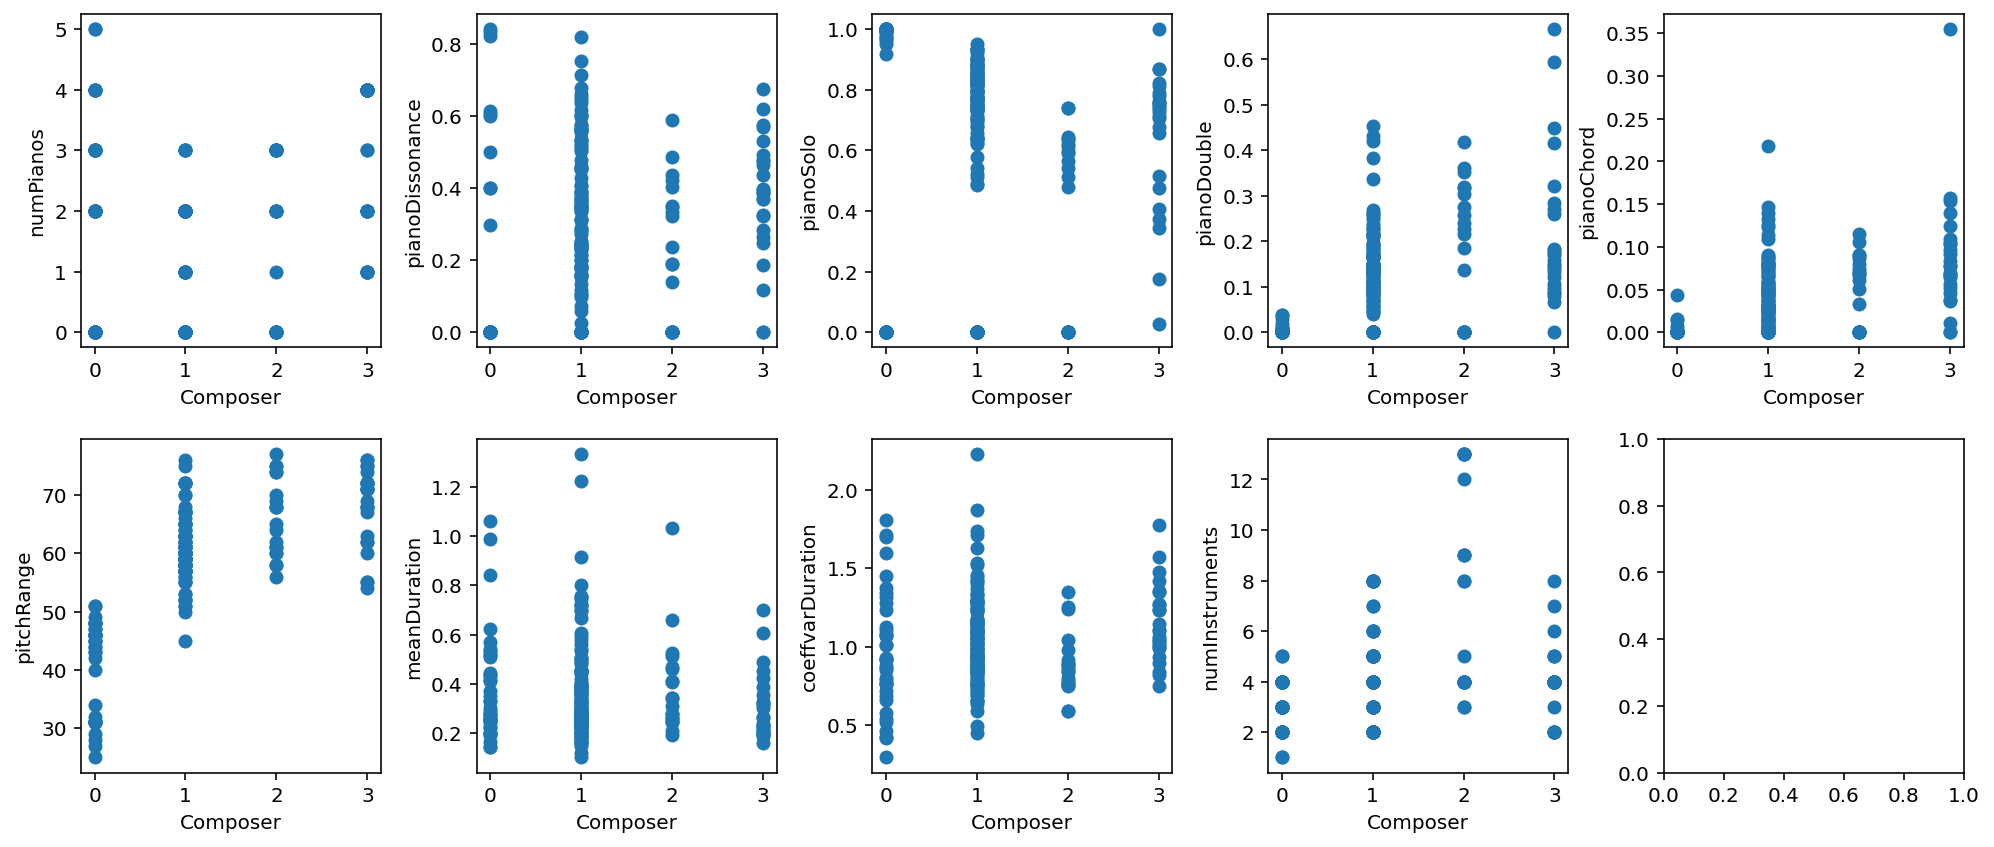

In [28]:
#################################################################################
###################            EXPLORE PS1 DATASET            ###################
#################################################################################
plt.rcParams['figure.figsize'] = [14, 6]
fig, axs = plt.subplots(2,5)
axs[0][0].scatter(dataFrame['Composer'],dataFrame['numPianos'])
axs[0][0].set(xlabel='Composer',ylabel='numPianos')
axs[0][1].scatter(dataFrame['Composer'],dataFrame['pianoDissonance'])
axs[0][1].set(xlabel='Composer',ylabel='pianoDissonance')
axs[0][2].scatter(dataFrame['Composer'],dataFrame['pianoSolo'])
axs[0][2].set(xlabel='Composer',ylabel='pianoSolo')
axs[0][3].scatter(dataFrame['Composer'],dataFrame['pianoDouble'])
axs[0][3].set(xlabel='Composer',ylabel='pianoDouble')
axs[0][4].scatter(dataFrame['Composer'],dataFrame['pianoChord'])
axs[0][4].set(xlabel='Composer',ylabel='pianoChord')
axs[1][0].scatter(dataFrame['Composer'],dataFrame['pitchRange'])
axs[1][0].set(xlabel='Composer',ylabel='pitchRange')
axs[1][1].scatter(dataFrame['Composer'],dataFrame['meanDuration'])
axs[1][1].set(xlabel='Composer',ylabel='meanDuration')
axs[1][2].scatter(dataFrame['Composer'],dataFrame['coeffvarDuration'])
axs[1][2].set(xlabel='Composer',ylabel='coeffvarDuration')
axs[1][3].scatter(dataFrame['Composer'],dataFrame['numInstruments'])
axs[1][3].set(xlabel='Composer',ylabel='numInstruments')
fig.tight_layout()
plt.show()

***       BRIEF DATA EXPLORATION COMMENTS     ***

In the plots above, I have plotted the values for each composer across a variety of different potential features.  There is potentially some significance in the Piano quantities (across the top row), but due to the fact that many pieces of music have 0 pianos, it makes it difficult to have a general model that depends on piano derived quantities.

In the bottom row, some more general quantities, that are applicable to the piece and not just a particular instrument are shown.  Some clear variation in the `pitchRange` and `numInstruments` across composers is apparent.  The `meanDuration` and `coeffVarDuration` shows a little variability in the spread of values, so there could be some significance there.

Of course, we are only looking at one-class of the classifier, the `is written by one of the 4 composers`.  So it's unclear if these will be good candidates when trying to classify pieces of music that are not by one of these 4 composers, but any variability across the composer groups could suggest a derived quantity that will vary outside of this group as well.

Due to the limitation of derived quantities created so far and the somewhat open-ended nature of a one-sided classifier, the bottom row of (`pitchRange, meanDuration, coeffvarDuation, numInstruments`) seems like a good place to start with model building.

***       QUICK NOTE      ***

The cells below are basically a copy of the above for use on PS2, with a few minor changes.  If I had some more time, I would like to go back and collapse these into a single file, but I wanted to move on to the building of the Classifier, so I've some things in the code here that aren't ideal.

In [29]:
#################################################################################
###################             CREATE PS2 DATASET            ###################
#################################################################################       
        
# NOTE: Store the piece information instead of the composer for final analysis
columns = ['Piece','numInstruments','numPianos','numCellos','numPizzis','numViolins','numViolas',
           'numFrenchHorns','numOboes','numClarinets','numBassoons','numContras','numHarps','numFlutes',
           'otherInstPct','pianoDissonance','pianoSolo','pianoDouble',
           'pianoChord','pitchRange','meanDuration', 'coeffvarDuration']

dataset = []
for pFile in glob.glob('MusicNet/PS2/' + "pickle/*"):
    try:
        pMidi = pickle.load( open( pFile, "rb" ) )
        music = pMidi.music

        numPianos = 0
        numCellos = 0
        numViolins = 0
        numViolas = 0
        numFrenchHorns = 0
        numOboes = 0
        numClarinets = 0
        numBassoons = 0
        numPizzis = 0
        numContras = 0
        numFlutes = 0
        numHarps = 0
        numOthers = 0
        pianoDissonance = 0
        pianoDissonanceDenom = 0
        pianoDissonanceNumer = 0
        pianoSoloPct = 0
        pianoSoloPctNumer = 0
        pianoDoublePct = 0
        pianoDoublePctNumer = 0
        pianoChordPct = 0
        pianoChordPctNumer = 0
        pianoStacksDenom = 0
        pitchMin = 10000
        pitchMax = -10000
        durArray = np.array([])

        for instrument in music:
            pitchMin = np.min([pitchMin, instrument['notes']['pitch'].min()])
            pitchMax = np.max([pitchMax, instrument['notes']['pitch'].max()])
            durArray = np.concatenate((durArray, np.array(instrument['notes']['duration'])))

            if (instrument['name'] == 'Acoustic Grand Piano'):
                numPianos = numPianos + 1
                thisPianoDissonanceDenom = 0 
                for key, value in instrument['vertStacks'].items():
                    if (key > 1):
                        thisPianoDissonanceDenom += value
                pianoDissonanceNumer += instrument['dissonancePct'] * thisPianoDissonanceDenom
                pianoDissonanceDenom += thisPianoDissonanceDenom
                if (1 in instrument['vertStacks']):
                    pianoSoloPctNumer += instrument['vertStacks'][1] 
                if (2 in instrument['vertStacks']):
                    pianoDoublePctNumer += instrument['vertStacks'][2]
                if (3 in instrument['vertStacks']):
                    pianoChordPctNumer += instrument['vertStacks'][3]
                if (1 in instrument['vertStacks']):
                    pianoStacksDenom += instrument['vertStacks'][1] + thisPianoDissonanceDenom

            elif (instrument['name'] == 'Violin'):
                numViolins = numViolins + 1

            elif (instrument['name'] == 'Viola'):
                numViolas = numViolas + 1

            elif ((instrument['name'] == 'Cello') or (instrument['name'] == 'Violincello')):
                numCellos = numCellos + 1

            elif (instrument['name'] == 'French Horn'):
                numFrenchHorns = numFrenchHorns + 1

            elif (instrument['name'] == 'Oboe'):
                numOboes = numOboes + 1

            elif (instrument['name'] == 'Clarinet'):
                numClarinets = numClarinets + 1

            elif (instrument['name'] == 'Bassoon'):
                numBassoons = numBassoons + 1
                
            elif (instrument['name'] == 'Contrabass'):
                numContras = numContras + 1
                
            elif (instrument['name'] == 'Harpsichord'):
                numHarps = numHarps + 1
                
            elif (instrument['name'] == 'Flute'):
                numFlutes = numFlutes + 1
                
            elif (instrument['name'] == 'Pizzicato Strings'):
                numPizzis = numPizzis + 1

            else:
                numOthers = numOthers + 1
                print (instrument['name'])

        if (numPianos > 0):
            if (pianoDissonanceDenom > 0):
                pianoDissonance = pianoDissonanceNumer / pianoDissonanceDenom
            if (pianoStacksDenom > 0):
                pianoSoloPct = pianoSoloPctNumer / pianoStacksDenom
                pianoDoublePct = pianoDoublePctNumer / pianoStacksDenom
                pianoChordPct = pianoChordPctNumer / pianoStacksDenom

        dataset.append([pMidi.piece, pMidi.numInstruments, numPianos, numCellos, numPizzis, numViolins, numViolas, 
             numFrenchHorns, numOboes, numClarinets, numBassoons, numContras, numHarps, numFlutes, 
             numOthers / pMidi.numInstruments, pianoDissonance, pianoSoloPct, pianoDoublePct, 
             pianoChordPct, pitchMax - pitchMin, durArray.mean(), durArray.std()/durArray.mean()])
    except:
        print ("Error processing", pFile, "skipping...")
        
dataFrame = pd.DataFrame(dataset, columns=columns)

fname = "ps2Dataset.p"
pickle.dump(dataFrame, open( fname, "wb" ) )

In [100]:
#################################################################################
###################           CREATE PS2-30 DATASET           ###################
#################################################################################       
        
# NOTE: Store the piece information instead of the composer for final analysis
columns = ['Piece','numInstruments','numPianos','numCellos','numPizzis','numViolins','numViolas',
           'numFrenchHorns','numOboes','numClarinets','numBassoons','numContras','numHarps','numFlutes',
           'otherInstPct','pianoDissonance','pianoSolo','pianoDouble',
           'pianoChord','pitchRange','meanDuration', 'coeffvarDuration']

dataset = []
for pFile in glob.glob('MusicNet/PS2/' + "pickle-30/*"):
    try:
        pMidi = pickle.load( open( pFile, "rb" ) )
        music = pMidi.music

        numPianos = 0
        numCellos = 0
        numViolins = 0
        numViolas = 0
        numFrenchHorns = 0
        numOboes = 0
        numClarinets = 0
        numBassoons = 0
        numPizzis = 0
        numContras = 0
        numFlutes = 0
        numHarps = 0
        numOthers = 0
        pianoDissonance = 0
        pianoDissonanceDenom = 0
        pianoDissonanceNumer = 0
        pianoSoloPct = 0
        pianoSoloPctNumer = 0
        pianoDoublePct = 0
        pianoDoublePctNumer = 0
        pianoChordPct = 0
        pianoChordPctNumer = 0
        pianoStacksDenom = 0
        pitchMin = 10000
        pitchMax = -10000
        durArray = np.array([])

        for instrument in music:
            pitchMin = np.min([pitchMin, instrument['notes']['pitch'].min()])
            pitchMax = np.max([pitchMax, instrument['notes']['pitch'].max()])
            durArray = np.concatenate((durArray, np.array(instrument['notes']['duration'])))

            if (instrument['name'] == 'Acoustic Grand Piano'):
                numPianos = numPianos + 1
                thisPianoDissonanceDenom = 0 
                for key, value in instrument['vertStacks'].items():
                    if (key > 1):
                        thisPianoDissonanceDenom += value
                pianoDissonanceNumer += instrument['dissonancePct'] * thisPianoDissonanceDenom
                pianoDissonanceDenom += thisPianoDissonanceDenom
                if (1 in instrument['vertStacks']):
                    pianoSoloPctNumer += instrument['vertStacks'][1] 
                if (2 in instrument['vertStacks']):
                    pianoDoublePctNumer += instrument['vertStacks'][2]
                if (3 in instrument['vertStacks']):
                    pianoChordPctNumer += instrument['vertStacks'][3]
                if (1 in instrument['vertStacks']):
                    pianoStacksDenom += instrument['vertStacks'][1] + thisPianoDissonanceDenom

            elif (instrument['name'] == 'Violin'):
                numViolins = numViolins + 1

            elif (instrument['name'] == 'Viola'):
                numViolas = numViolas + 1

            elif ((instrument['name'] == 'Cello') or (instrument['name'] == 'Violincello')):
                numCellos = numCellos + 1

            elif (instrument['name'] == 'French Horn'):
                numFrenchHorns = numFrenchHorns + 1

            elif (instrument['name'] == 'Oboe'):
                numOboes = numOboes + 1

            elif (instrument['name'] == 'Clarinet'):
                numClarinets = numClarinets + 1

            elif (instrument['name'] == 'Bassoon'):
                numBassoons = numBassoons + 1
                
            elif (instrument['name'] == 'Contrabass'):
                numContras = numContras + 1
                
            elif (instrument['name'] == 'Harpsichord'):
                numHarps = numHarps + 1
                
            elif (instrument['name'] == 'Flute'):
                numFlutes = numFlutes + 1
                
            elif (instrument['name'] == 'Pizzicato Strings'):
                numPizzis = numPizzis + 1

            else:
                numOthers = numOthers + 1
                print (instrument['name'])

        if (numPianos > 0):
            if (pianoDissonanceDenom > 0):
                pianoDissonance = pianoDissonanceNumer / pianoDissonanceDenom
            if (pianoStacksDenom > 0):
                pianoSoloPct = pianoSoloPctNumer / pianoStacksDenom
                pianoDoublePct = pianoDoublePctNumer / pianoStacksDenom
                pianoChordPct = pianoChordPctNumer / pianoStacksDenom

        dataset.append([pMidi.piece, pMidi.numInstruments, numPianos, numCellos, numPizzis, numViolins, numViolas, 
             numFrenchHorns, numOboes, numClarinets, numBassoons, numContras, numHarps, numFlutes, 
             numOthers / pMidi.numInstruments, pianoDissonance, pianoSoloPct, pianoDoublePct, 
             pianoChordPct, pitchMax - pitchMin, durArray.mean(), durArray.std()/durArray.mean()])
    except:
        print ("Error processing", pFile, "skipping...")
        
dataFrame = pd.DataFrame(dataset, columns=columns)

fname = "ps2Dataset-30.p"
pickle.dump(dataFrame, open( fname, "wb" ) )

In [548]:
#### MUSIC21 Wrapper Class -- Unused for now ####

class ProcessMidi():
    def __init__(self, filepath):
        self.filepath = filepath
        self.composer = self.filepath.split('/')[-2].split('/')[0]
        self.piece = self.filepath.split('/')[-1].split('_')[0]
        self.midiFile = music21.midi.MidiFile()
        self.readMidi()

    def readMidi(self):
        self.midiFile.open(self.filepath)
        self.midiFile.read()
        
    def streamFile(self):
        self.stream = music21.midi.translate.midiFileToStream(self.midiFile)
        
    def parseFile(self):
        self.parse = music21.converter.parse(self.filepath)
        
    def extractSnippet(self, start, length):
        snippet = None
        # extract a snippet from the file of specified length
        return snippet
    
    def extractRandomSnippet(self, length):
        # calculate a random point <= time - length
        return self.extractSnippet(start, length)
    
    def parseMacroData(self):
        self.parts = self.stream.parts
        
        flattened = self.stream.flatten()
        self.notesAndRests = flattened.notesAndRests
        self.notes = flattened.notes
        self.pitches = flattened.pitches
        self.secondsMap = flattened.secondsMap

    def parseParts(self):
        flattened = self.stream.flatten()

        self.secondsMap = flattened.secondsMap
        self.spanners = flattened.spanners
        self.variants = flattened.variants
        self.voice = flattened.voices
        self.clef = flattened.clef
        self.duration = flattened.duration
        self.elements = flattened.elements
        self.keySignature = flattened.keySignature
        self.metadata = flattened.metadata
        
    def calculateStatistics(self):
        pass
    
    def giveSummary(self):
        self.composer = self.filepath.split('/')[-2].split('/')[0]
        self.piece = self.filepath.split('/')[-1].split('_')[0]
        
    def examineFile(self):
        for element in self.stream.recurse():
            if (type(element) == music21.note.Note):
                print (element.pitch, element.volume.velocity, measureOffset + element.offset, measureOffset + element.offset+element.duration.quarterLength)
            if (type(element) == music21.key.Key):
                print (element.name)
            if (type(element) == music21.meter.TimeSignature):
                print ('TimeSignature', element.ratioString)
            if (type(element) == music21.tempo.MetronomeMark):
                print (element.text, element.getQuarterBPM())
            if (type(element) == music21.stream.Measure):
                measureOffset = element.offset
            try:
                print (element.instrumentName)
            except:
                #print (element)
                pass